# Segmentando clientes

En esta notebook se verá una forma sobre como segmentar a los clientes, cuando cuenta con una gran cantidad de estos sobre una base de datos de una gran (?) cantidad de dimensiones.

Empezaremos cargando el entorno e instalando los requerimentos necesarios.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

In [2]:
base_path = 'C:/Users/pedro/Documents/DMEyF/dmeyf2025/'
dataset_path = base_path + 'data/processed/'
modelos_path = base_path + 'models/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01_fe.csv'

In [3]:
df_train = pd.read_csv(dataset_path + dataset_file)

Solo segmentaremos a los clientes de abril, dado que necesitaremos variables en algún momento agregar variables históricas para entender su comportamiento previo a la **baja**

In [4]:
df_train = df_train[df_train['foto_mes']==202104]

A su vez, nos concentraremos en el fenómeno de la **baja**. No importa si es en un mes o si es en dos.

In [5]:
Xtrain = df_train
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
Xtrain = Xtrain.drop("clase_ternaria", axis=1)

del(df_train)

Lo primero que necesitamos es saber cuando un cliente es parecido a otro. Todos los clientes que son parecidos los juntaremos en un **segmento** y sobre esos segmentos haremos perfilados o profiles para entender que los caracteriza.

Saber cuando un cliente es parecido a otro no es algo tan simple en un problema de alta dimensionalidad, lo que se suele llamar **curse of dimensionality**. Las cosas no son lo mismo más allá de nuestras 3 escasas dimensiones. Para muestra, un botón: https://www.youtube.com/watch?v=mceaM2_zQd8

Por esto, es conveniente usar herramientas que nos ayuden a no tener que hacer distancias euclídeas.

Empecemos con una ayuda con nos dan nuestros amigos, los **rf** con una original matriz de distancias (https://en.wikipedia.org/wiki/Distance_matrix)

La **Random Forest Distance** es una matriz derivada del algoritmo Random Forest,

+ Se utiliza para medir la similitud entre pares de puntos de datos. Esta métrica se basa en la idea de cuántas veces dos puntos de datos terminan en la misma hoja de un árbol en un **rf**, entre los múltiples árboles que se generan.

+ Cómo se Calcula?

 1. Se entrena un **rf**.
 2. Para cada par de clientes $c_i$ y $c_j$, se observa cuántas veces caen en la misma hoja a través de todos los árboles del bosque. Luego se agrega en la posición $i$, $j$ de una matriz el número de veces que coincidieron esos dos clientes en un nodo terminal.
 3. Se calcula la matriz de distancia como **1 - proporción de veces que caen en la misma hoja**. Ejemplo: Si caen en la misma hoja el 90% de las veces, su distancia será 0.1. Si nunca caen en la misma hoja, la distancia es 1.

Veamoslo aplicado en nuestro caso

Para trabajar con este algoritmo no vamos a trabajar con todos los datos. Usted decida con cuantos trabajar. En este caso, tomaremos todos los **baja** y unos 2000 **continua**, ya que queremos como interactuan los segmentos de clientes que se van con los que se quedan.


In [6]:
np.random.seed(42)
continua_sample = ytrain[ytrain == 0].sample(5000).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

Xtrain_rf = Xtrain.loc[rf_index]
ytrain_rf = ytrain.loc[rf_index]

Entrenamos un simple **rf**, despliegue sus herramientas aprendidas para contar con un buen modelo


In [7]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf)


model = RandomForestClassifier(n_estimators=100, max_features=30, min_samples_leaf=20, random_state=17)
model.fit(Xtrain_rf_imp, ytrain_rf)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,20
,min_weight_fraction_leaf,0.0
,max_features,30
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
# param_grid = {
#     "n_estimators": [100, 200, 300, 500],
#     "max_features": [10, 20, 30, 50],
#     "min_samples_leaf": [1, 5, 10, 20]
# }

# grid = GridSearchCV(
#     RandomForestClassifier(random_state=17),
#     param_grid,
#     cv=10,
#     scoring="f1",
#     n_jobs=-1
# )
# grid.fit(Xtrain_rf_imp, ytrain_rf)

# print("Mejores parámetros:", grid.best_params_)

In [9]:
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier(
    n_estimators=500,
    max_features=50,
    min_samples_leaf=1,
    random_state=17,
    n_jobs=-1
)

roc_auc = cross_val_score(
    model,
    Xtrain_rf,
    ytrain_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC-AUC promedio (CV):", roc_auc.mean())
print("Desviación estándar:", roc_auc.std())

model.fit(Xtrain_rf_imp, ytrain_rf)

ROC-AUC promedio (CV): 0.9156064748201439
Desviación estándar: 0.006685940876540629


,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,50
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Armamos (copiamos de internet) una función que nos calcule la matriz de distancias

In [10]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

md = distanceMatrix(model, Xtrain_rf_imp)

Veamos como se ve. Recuerde que significa que un número esté cerca de 0 o que esté cerca de 1.

In [11]:
md

array([[0.   , 1.   , 1.   , ..., 0.996, 1.   , 1.   ],
       [1.   , 0.   , 0.236, ..., 0.998, 0.442, 0.508],
       [1.   , 0.236, 0.   , ..., 1.   , 0.408, 0.472],
       ...,
       [0.996, 0.998, 1.   , ..., 0.   , 1.   , 0.998],
       [1.   , 0.442, 0.408, ..., 1.   , 0.   , 0.598],
       [1.   , 0.508, 0.472, ..., 0.998, 0.598, 0.   ]],
      shape=(7085, 7085))

Para poder visualizar la matriz, utilizaremos un embedding. Los *embeddings* son representaciones vectoriales de datos en un espacio de menor dimensión

Podría utilizar un **PCA** con ese fin, pero en los últimos años hay mejores algoritmos como **t-sne** o **umap**.

UMAP (Uniform Manifold Approximation and Projection) es una técnica avanzada para la reducción de dimensionalidad y visualización de datos en espacios de menor dimensión, que busca mantener al máximo la estructura de los datos en alta dimensión.

1. **Preservación de la Estructura Global y Local**:
   - Intenta preservar tanto la estructura local (relaciones cercanas) como la global (estructura general) de los datos al proyectarlos en un espacio de menor dimensión.

2. **Basado en Manifold Learning**:
   - UMAP asume que los datos de alta dimensión se encuentran en un espacio de menor dimensión (un "manifold") y busca proyectar esos datos de manera que se mantenga esa estructura subyacente.

3. **Velocidad y Escalabilidad**:
   - UMAP es más rápido y escalable en comparación con técnicas similares como t-SNE, especialmente en conjuntos de datos grandes.

4. **Control sobre la Estructura**:
   - UMAP permite al usuario ajustar parámetros que controlan la preservación de la estructura local y global, como el número de vecinos cercanos (n_neighbors) y la distancia mínima entre puntos (min_dist).

Una característica adicional, es que cuenta con la posibilidad de recibir de entrada una matriz de distancia.

Veamos los datos por primera vez:

In [12]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="umap")

In [13]:
# # Ejemplo: matriz de hiperparámetros (cada fila es una combinación)
# param_grid = pd.DataFrame([
#     {"n_neighbors": 50, "min_dist": 0.5, "learning_rate": 0.5},
#     {"n_neighbors": 70, "min_dist": 0.5, "learning_rate": 0.5},
#     {"n_neighbors": 90, "min_dist": 0.5, "learning_rate": 0.5},
#     {"n_neighbors": 100, "min_dist": 0.5, "learning_rate": 0.5},
#     {"n_neighbors": 120, "min_dist": 0.5, "learning_rate": 0.5},
# ])

# # Probabilidades de la clase 1
# class_index = np.where(model.classes_ == 1)[0]
# prob_baja = model.predict_proba(Xtrain_rf_imp)[:, class_index].ravel()

# # Loop por cada fila de la matriz
# for i, row in param_grid.iterrows():
#     print(f"\n--- Iteración {i+1}: {row.to_dict()} ---")

#     # 1. UMAP con los hiperparámetros de la fila
#     embedding_rf = UMAP(
#         n_components=2,
#         n_neighbors=int(row["n_neighbors"]),
#         min_dist=float(row["min_dist"]),
#         learning_rate=float(row["learning_rate"]),
#         metric="precomputed",   # cuidado: asegúrate que md sea una matriz de distancias
#         random_state=17
#     ).fit_transform(md)

#     # 2. Gráfico 1: coloreado por probabilidad
#     plt.figure(figsize=(10, 6))
#     plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=prob_baja, cmap="coolwarm", s=10)
#     plt.colorbar(label="Probabilidad clase 1")
#     plt.title(f"UMAP Probabilidades (iter {i+1})")
#     plt.show()

#     # 3. Gráfico 2: clustering con KMeans
#     kmeans = KMeans(n_clusters=3, random_state=17, n_init=10)
#     clusters = kmeans.fit_predict(embedding_rf)

#     plt.figure(figsize=(10, 6))
#     plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=clusters, cmap="viridis", s=10)
#     plt.colorbar(label="Cluster")

#     # Anotar centroides
#     for cluster_label in sorted(np.unique(clusters)):
#         cluster_points = embedding_rf[clusters == cluster_label]
#         centroid = cluster_points.mean(axis=0)
#         plt.text(centroid[0], centroid[1], str(cluster_label), fontsize=12, ha="center", va="center",
#                  color="black", bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.5))

#     plt.title(f"UMAP Clusters (iter {i+1})")
#     plt.show()

#     # Anotar % de Clustering
#     cluster_class_df = pd.DataFrame({'cluster': clusters, 'original_class': ytrain_rf})

#     class_distribution_by_cluster = cluster_class_df.groupby('cluster')['original_class'].value_counts().unstack(fill_value=0)
#     cluster_prob_df = pd.DataFrame({'cluster': clusters, 'prob_baja': prob_baja.flatten()})
#     average_prob_baja_by_cluster = cluster_prob_df.groupby('cluster')['prob_baja'].mean()
#     class_distribution_by_cluster['average_prob_baja'] = average_prob_baja_by_cluster

#     print("Number of cases per class and average churn probability per cluster:")
#     print(class_distribution_by_cluster)

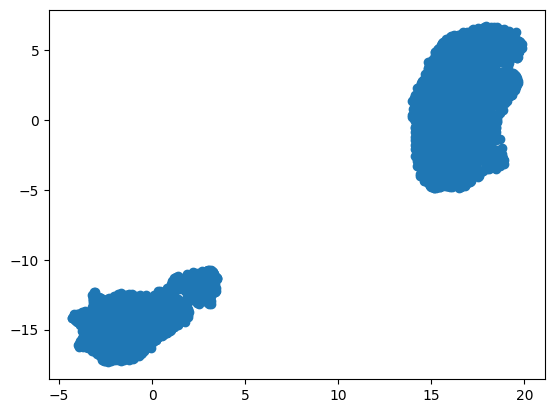

In [14]:
embedding_rf = UMAP(
  n_components=2,
  n_neighbors=120,
  min_dist=0.5,
  learning_rate=0.5,
  metric="precomputed",
  random_state=17,
).fit_transform(md)

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

Agreguemos la dimensión de la probabilidad de salida, para ver donde cree el modelo que se encuentran los **bajas**.

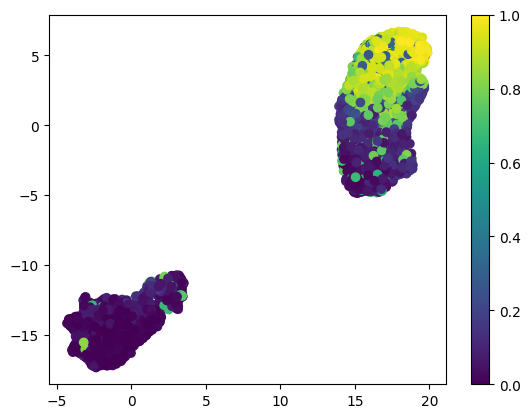

In [15]:
class_index = np.where(model.classes_ == 1)[0]
prob_baja = model.predict_proba(Xtrain_rf_imp)[:,class_index]

plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja)
plt.colorbar()
plt.show()

Vamos a partir de este embedding para segmentar a los clientes. Puede utilizar cualquier técnica, los datos ya son simples para cualquier algoritmo. Utilizaremos uno bastante estandar

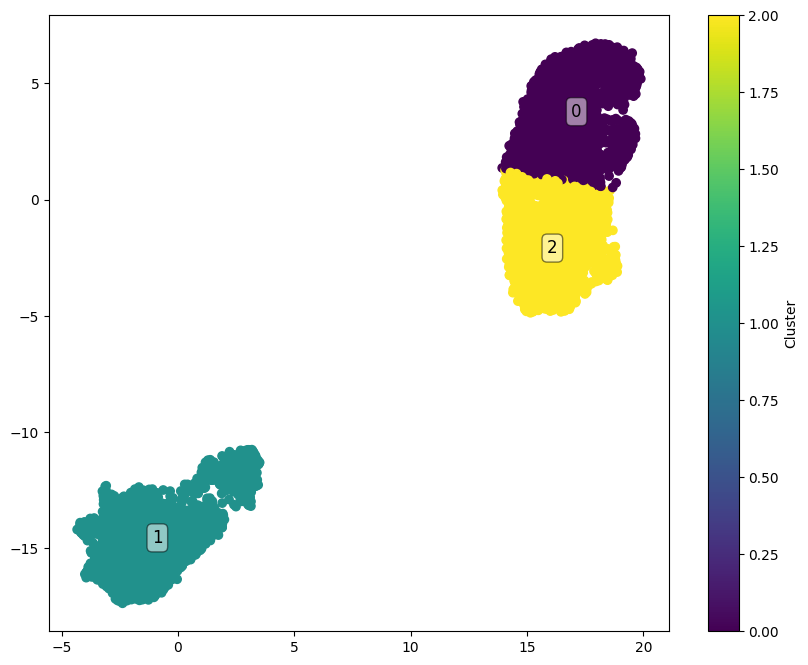

In [16]:
kmeans = KMeans(n_clusters=3, random_state=15, n_init=15)
clusters = kmeans.fit_predict(embedding_rf)


plt.figure(figsize=(10, 8))
plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=clusters, cmap='viridis')
plt.colorbar(label='Cluster')

for cluster_label in sorted(np.unique(clusters)):
    cluster_points = embedding_rf[clusters == cluster_label]
    centroid = cluster_points.mean(axis=0)
    plt.text(centroid[0], centroid[1], str(cluster_label), fontsize=12, ha='center', va='center', color='black',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))

plt.show()

Veamos cuales de los clientes de cada cluster son **bajas** y cuales **continuan** y la proba promedio del cluster

In [17]:
cluster_class_df = pd.DataFrame({'cluster': clusters, 'original_class': ytrain_rf})

class_distribution_by_cluster = cluster_class_df.groupby('cluster')['original_class'].value_counts().unstack(fill_value=0)
cluster_prob_df = pd.DataFrame({'cluster': clusters, 'prob_baja': prob_baja.flatten()})
average_prob_baja_by_cluster = cluster_prob_df.groupby('cluster')['prob_baja'].mean()
class_distribution_by_cluster['average_prob_baja'] = average_prob_baja_by_cluster

print("Number of cases per class and average churn probability per cluster:")
print(class_distribution_by_cluster)

Number of cases per class and average churn probability per cluster:
original_class     0     1  average_prob_baja
cluster                                      
0                394  1673           0.772680
1               2751    99           0.042990
2               1855   313           0.173996


In [18]:
from sklearn.metrics import r2_score

# Promedio global de prob_baja
global_mean = cluster_prob_df['prob_baja'].mean()

# Suma de cuadrados total
ss_total = ((cluster_prob_df['prob_baja'] - global_mean) ** 2).sum()

# Suma de cuadrados dentro de los clusters
ss_within = 0
for c in cluster_prob_df['cluster'].unique():
    cluster_vals = cluster_prob_df[cluster_prob_df['cluster'] == c]['prob_baja']
    cluster_mean = cluster_vals.mean()
    ss_within += ((cluster_vals - cluster_mean) ** 2).sum()

# Varianza explicada
ss_between = ss_total - ss_within
r2_clusters = ss_between / ss_total

print(f"R² entre clusters respecto a prob_baja: {r2_clusters:.3f}")

R² entre clusters respecto a prob_baja: 0.683


In [19]:
def gini(p):
    return 1 - np.sum((p/np.sum(p))**2)

gini_values = []
for c in class_distribution_by_cluster.index:
    counts = class_distribution_by_cluster.loc[c, ytrain_rf.unique()]
    gini_values.append(gini(counts.values))

avg_gini = np.mean(gini_values)
print(f"Gini promedio de los clusters: {avg_gini:.3f}")

Gini promedio de los clusters: 0.208


Por último necesitamos alguna forma de saber que hace a cada cluster distinto del otro. Para esto utilizaremos modelos (**rf**) que buscan separar los cluster uno a uno del resto de los datos.

Por cada modelo, miraremos cuales son las variables más importantes que separan los datos para luego caracterizarlos:

Manos a la obra:

Y exploramos las diferencias entre los clusters usando las **n** variables más importantes, usando en este caso la mediana


In [20]:
# sacar las features más importantes
importances = model.feature_importances_
feature_names = Xtrain_rf.columns
feature_importance_series = pd.Series(importances, index=feature_names)

feature_selected = feature_importance_series.sort_values(ascending=False)

n_top = 40 # cantidad de variables a evaluar.
top_overall_features = feature_selected.head(n_top).index.tolist()

cluster_series_aligned = pd.Series(clusters, index=Xtrain_rf.index)

cluster_median_values = {}

for cluster in sorted(np.unique(clusters)):
    cluster_indices = cluster_series_aligned[cluster_series_aligned == cluster].index
    cluster_data = Xtrain_rf.loc[cluster_indices, top_overall_features]

    # Usar el estadístico de su preferencia
    values = cluster_data.mean()
    cluster_median_values[f'Cluster {cluster}'] = values

# Construir DataFrame
top_overall_features_df = pd.DataFrame(cluster_median_values)

# ➕ Agregar columna con importancia de cada variable
top_overall_features_df["Importance"] = feature_selected.loc[top_overall_features]

# Reordenar para que la columna Importance quede al inicio
cols = ["Importance"] + [c for c in top_overall_features_df.columns if c != "Importance"]
top_overall_features_df = top_overall_features_df[cols]

display(top_overall_features_df)

,Importance,Cluster 0,Cluster 1,Cluster 2
ctrx_quarter_avg_3,0.021178,23.470851,130.149591,126.673278
ctrx_quarter,0.020213,20.315433,130.779649,127.028598
ctrx_quarter_lag_1,0.019591,22.554691,130.186013,126.334106
ctrx_quarter_min_3,0.017179,17.228834,117.785614,113.350092
ctrx_quarter_lag_2,0.014715,24.604606,132.534800,128.169159
ctarjeta_total_transacciones,0.013910,2.215288,26.631579,23.330258
ctrx_quarter_max_3,0.013474,30.127721,142.355789,140.111162
ctrx_quarter_lag_3,0.012917,26.934975,130.279621,126.881827
mcaja_ahorro,0.012397,5935.614451,84134.443154,77345.159004
mpasivos_margen,0.010572,144.886913,1482.304761,1901.740129


Otra de forma de explorar es graficar uno contra todos

In [21]:
def compare_cluster_stats_all(data, clusters, target_cluster):
    """
    Compara medias y medianas de todas las variables numéricas
    entre un cluster específico y el resto de clusters.

    Parameters
    ----------
    data : pd.DataFrame
        Dataset con las variables (solo numéricas serán consideradas).
    clusters : array-like
        Asignaciones de cluster para cada fila.
    target_cluster : int o str
        Cluster a analizar.

    Returns
    -------
    pd.DataFrame
        Tabla con media y mediana del cluster vs resto,
        ordenada por diferencia absoluta en la media.
    """

    cluster_series_aligned = pd.Series(clusters, index=data.index)

    # Separar cluster vs resto
    target_indices = cluster_series_aligned[cluster_series_aligned == target_cluster].index
    rest_indices = cluster_series_aligned[cluster_series_aligned != target_cluster].index

    target_data = data.loc[target_indices]
    rest_data = data.loc[rest_indices]

    # Solo variables numéricas
    num_cols = data.select_dtypes(include=[np.number]).columns

    stats = []
    for col in num_cols:
        mean_target = target_data[col].mean()
        median_target = target_data[col].median()
        mean_rest = rest_data[col].mean()
        median_rest = rest_data[col].median()
        diff_mean = abs(mean_target - mean_rest)/abs(mean_rest) if mean_rest != 0 else 1

        stats.append({
            "Variable": col,
            f"Cluster {target_cluster} - Mean": mean_target,
            f"Cluster {target_cluster} - Median": median_target,
            "Rest - Mean": mean_rest,
            "Rest - Median": median_rest,
            "Diff Mean Abs": diff_mean
        })

    # Convertir a DataFrame y ordenar
    result = pd.DataFrame(stats).sort_values("Diff Mean Abs", ascending=False).reset_index(drop=True)

    return result

compare_cluster_stats_all(Xtrain_rf, clusters, 1).head(20)

,Variable,Cluster 1 - Mean,Cluster 1 - Median,Rest - Mean,Rest - Median,Diff Mean Abs
0,mpayroll_min_3,85812.592021,7.196133e+04,3.652224,0.00,23494.980662
1,cpayroll_min_3,0.939649,1.000000e+00,0.000472,0.00,1988.707018
2,cpayroll_trx_min_3,1.258947,1.000000e+00,0.000708,0.00,1776.214035
3,mpayroll,138171.803361,9.963171e+04,201.863639,0.00,683.480891
4,cpayroll_trx,1.670877,1.000000e+00,0.009209,0.00,180.440126
5,mpayroll2,290.555635,0.000000e+00,1.661865,0.00,173.837044
6,cpayroll,0.997895,1.000000e+00,0.006139,0.00,161.541700
7,mpasivos_margen_delta_1,-116.816639,-2.824500e+01,0.775603,-1.38,151.613900
8,Visa_madelantopesos_lag_1,50.264680,0.000000e+00,0.790165,0.00,62.612888
9,mtarjeta_visa_consumo_slope_3,1150.471846,1.741370e+02,20.096645,0.00,56.246961


In [22]:
def compare_cluster_stats(data, clusters, variable_name, target_cluster):

    cluster_series_aligned = pd.Series(clusters, index=data.index)

    variable_data = data[variable_name]

    target_cluster_indices = cluster_series_aligned[cluster_series_aligned == target_cluster].index
    target_cluster_data = variable_data.loc[target_cluster_indices] # Keep NaNs for counting

    rest_indices = cluster_series_aligned[cluster_series_aligned != target_cluster].index
    rest_data = variable_data.loc[rest_indices] # Keep NaNs for counting

    target_cluster_desc = target_cluster_data.dropna().describe()
    rest_desc = rest_data.dropna().describe()

    summary_df = pd.DataFrame({
        f'Cluster {target_cluster}': target_cluster_desc,
        f'Rest of Clusters': rest_desc
    })

    summary_df.loc['unique'] = [target_cluster_data.nunique(), rest_data.nunique()]
    summary_df.loc['missing'] = [target_cluster_data.isnull().sum(), rest_data.isnull().sum()]

    return summary_df

# print(f"'mcaja_ahorro' - Cluster 0 vs. Rest")
compare_cluster_stats(Xtrain_rf, clusters, 'mpayroll_min_3', 1)

,Cluster 1,Rest of Clusters
count,2850.000000,4235.000000
mean,85812.592021,3.652224
std,75489.577438,237.315047
min,0.000000,0.000000
25%,40088.737500,0.000000
50%,71961.335000,0.000000
75%,113919.542500,0.000000
max,993809.000000,15443.710000
unique,2570.000000,3.000000
missing,0.000000,0.000000


Muy interesante... pero no hay una brújula que nos ayude a ver que variables comparar?

Acá un salvavidas: Crea un modelo que busca separar los clusters del resto de los datos y nos devuelven las variables más importantes de esa separación

In [23]:
important_features_by_cluster = {}

for cluster in sorted(np.unique(clusters)):
    print(f"Training model for Cluster {cluster} vs. Rest...")
    y_binary = (cluster_series_aligned == cluster).astype(int)

    model = RandomForestClassifier(n_estimators=300, random_state=17, class_weight= {0: 3, 1:1}) # Added class_weight for imbalanced data
    model.fit(Xtrain_rf_imp, y_binary)

    importances = model.feature_importances_
    feature_names = Xtrain_rf.columns

    indices = np.argsort(importances)[::-1]

    important_features_by_cluster[cluster] = [feature_names[i] for i in indices]

Training model for Cluster 0 vs. Rest...
Training model for Cluster 1 vs. Rest...
Training model for Cluster 2 vs. Rest...


Vemos las más importantes para un cluster

In [24]:
important_features_by_cluster[2][0:30]

['cpayroll_trx',
 'cpayroll',
 'mpayroll',
 'ctrx_quarter_min_3',
 'ctrx_quarter_lag_2',
 'ctrx_quarter',
 'cpayroll_trx_avg_3',
 'mtarjeta_visa_consumo',
 'ctarjeta_total_transacciones_min_3',
 'cpayroll_avg_3',
 'mpayroll_max_3',
 'ctarjeta_credito_transacciones_min_3',
 'cpayroll_max_3',
 'cpayroll_lag_1',
 'ctrx_quarter_lag_1',
 'mpayroll_avg_3',
 'cpayroll_trx_max_3',
 'cpayroll_trx_min_3',
 'ctarjeta_total_transacciones_avg_3',
 'mtarjeta_credito_consumo',
 'cpayroll_trx_lag_1',
 'ctarjeta_credito_transacciones',
 'mpayroll_min_3',
 'ctarjeta_total_transacciones',
 'ctrx_quarter_lag_3',
 'ctarjeta_total_transacciones_lag_1',
 'cpayroll_min_3',
 'ctarjeta_credito_transacciones_lag_2',
 'ctrx_quarter_avg_3',
 'ctarjeta_visa_transacciones_min_3']

Y luego miramos los estadísticos

In [25]:
compare_cluster_stats(Xtrain_rf, clusters, 'mpayroll', 1)

,Cluster 1,Rest of Clusters
count,2.850000e+03,4235.000000
mean,1.381718e+05,201.863639
std,3.304151e+05,4716.554742
min,0.000000e+00,0.000000
25%,6.504159e+04,0.000000
50%,9.963171e+04,0.000000
75%,1.503542e+05,0.000000
max,1.499410e+07,226242.370000
unique,2.739000e+03,26.000000
missing,0.000000e+00,0.000000


Es perfecto? **NO** pero es orientativo

Luego resta, analizar los estadísticos de los datos de cada cluster para las variables importantes, comparar sus distribuciones con histogramas, boxplots, pivot tables, etc.


Junto con el diccionaro de datos, de sentido a lo que ve a través del análisis multivariado de datos.

Obviamente, esto es apenas mas que una semilla. Agregue las variables históricas, juegue con los **rf** y genere una segmentación pro, que encante a Miranda


In [26]:
cluster_objetivo = 0

Xtrain_cluster = Xtrain_rf.copy()  # para no modificarlo en memoria
Xtrain_cluster["cluster"] = clusters
Xtrain_cluster["is_target_cluster"] = (clusters == cluster_objetivo)
# Xtrain_cluster = Xtrain_cluster.drop(columns=["cluster"])

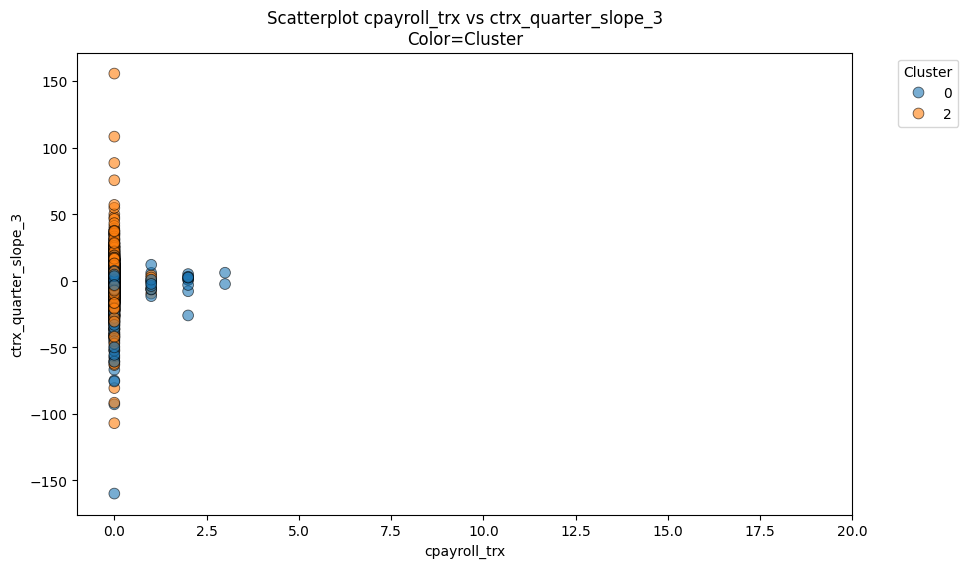

In [27]:
def scatter_clusters(df, x_var, y_var, cluster_col="cluster"):
    """
    Hace un scatterplot entre dos variables donde:
    - Color = cluster
    """
    # Paleta de colores para clusters
    palette = sns.color_palette("tab10", df[cluster_col].nunique())
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df,
        x=x_var,
        y=y_var,
        hue=cluster_col,
        palette=palette,
        edgecolor="black",
        alpha=0.6,
        s=60
    )
    
    plt.title(f"Scatterplot {x_var} vs {y_var}\nColor=Cluster")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
    # plt.ylim(0, 1e6)
    plt.xlim(-1,20)
    plt.show()

# Ejemplo de uso:
scatter_clusters(Xtrain_cluster.loc[Xtrain_cluster['cluster'] != 1], "cpayroll_trx", "ctrx_quarter_slope_3")

In [28]:
var_analysis = "mrentabilidad_annual"

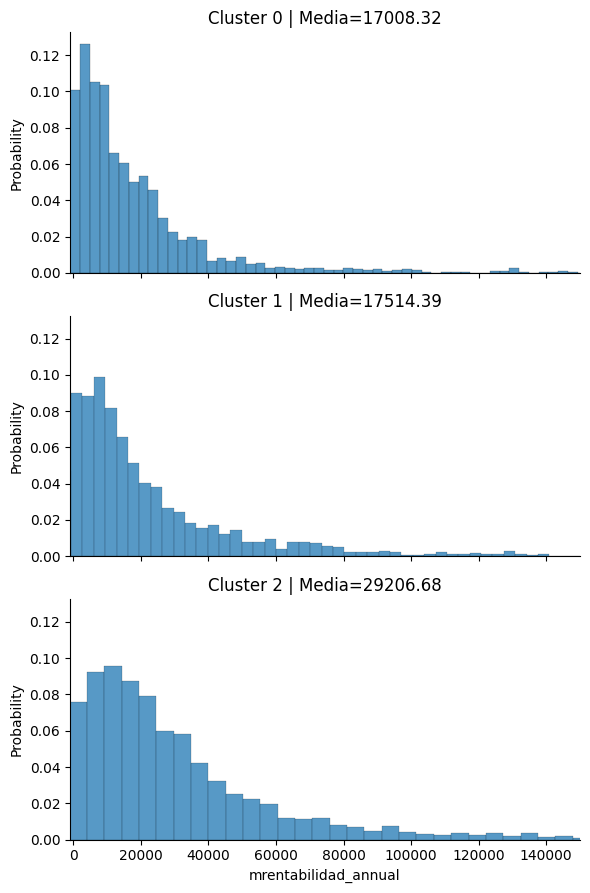

In [29]:
g = sns.FacetGrid(Xtrain_cluster, row="cluster", height=3, aspect=2)
g.map(sns.histplot, var_analysis, stat='probability')

# Recorremos cada subplot y le ponemos título con media y mediana
for cluster_val, ax in zip(Xtrain_cluster["cluster"].unique(), g.axes.flatten()):
    subset = Xtrain_cluster[Xtrain_cluster["cluster"] == cluster_val][var_analysis]
    media = subset.mean()
    ax.set_title(f"Cluster {cluster_val} | Media={media:.2f}")
    ax.set(xlim = (-1e3,1.5e5))

plt.show()

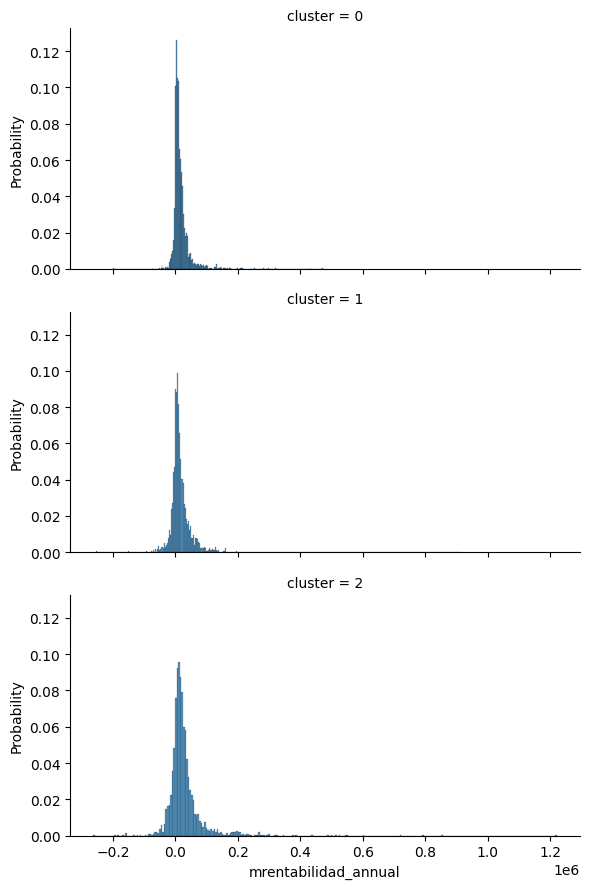

In [30]:
g = sns.FacetGrid(Xtrain_cluster, row="cluster", height=3, aspect=2)
g.map(sns.histplot, var_analysis, stat='probability')
# g.set(xlim = (-1e4,1e4))

[(0.0, 2000000.0)]

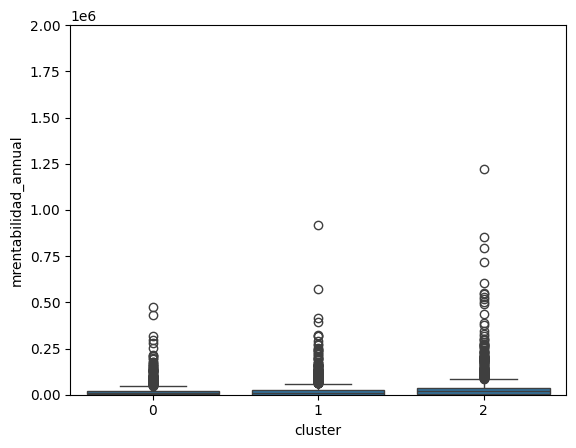

In [31]:
bp = sns.boxplot(x='cluster', y=var_analysis, data=Xtrain_cluster)
bp.set(ylim = (0,2e6))
# bp.show()

In [32]:
# Convertir Xtrain_rf_imp a DataFrame con nombres de columnas originales
Xtrain_rf_imp_df = pd.DataFrame(Xtrain_rf_imp, columns=Xtrain_rf.columns, index=Xtrain_rf.index)

# Unir con la variable target
df_with_target = Xtrain_rf_imp_df.copy()
df_with_target["target"] = ytrain_rf.values

# Agregar la columna de clusters
df_with_target["cluster"] = clusters

# Resultado
df_with_target.head()

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Credito_mlimitecompra_lag_1,Credito_mlimitecompra_lag_2,Credito_mlimitecompra_lag_3,Credito_mlimitecompra_delta_1,Credito_mlimitecompra_avg_3,Credito_mlimitecompra_max_3,Credito_mlimitecompra_min_3,Credito_mlimitecompra_slope_3,target,cluster
161,1.059218e+09,202104.0,1.0,0.0,1.0,44.0,87.0,16241.28,71180.10,2249.08,...,394128.0,394128.0,394128.0,0.0,394128.0,394128.0,394128.0,0.0,1,0
540,1.069486e+09,202104.0,1.0,0.0,0.0,40.0,84.0,1356.15,8995.06,438.37,...,168912.0,168912.0,168912.0,0.0,168912.0,168912.0,168912.0,0.0,0,1
856,1.075670e+09,202104.0,1.0,0.0,0.0,35.0,57.0,-903.13,-1726.80,762.41,...,394128.0,394128.0,394128.0,0.0,394128.0,394128.0,394128.0,0.0,0,1
898,1.076852e+09,202104.0,1.0,0.0,0.0,41.0,82.0,9454.27,42453.73,1676.17,...,394128.0,394128.0,394128.0,211140.0,211140.0,211140.0,211140.0,0.0,1,0
1211,1.084122e+09,202104.0,1.0,0.0,0.0,53.0,79.0,583.96,9180.40,145.48,...,394128.0,394128.0,394128.0,0.0,394128.0,394128.0,394128.0,0.0,0,2


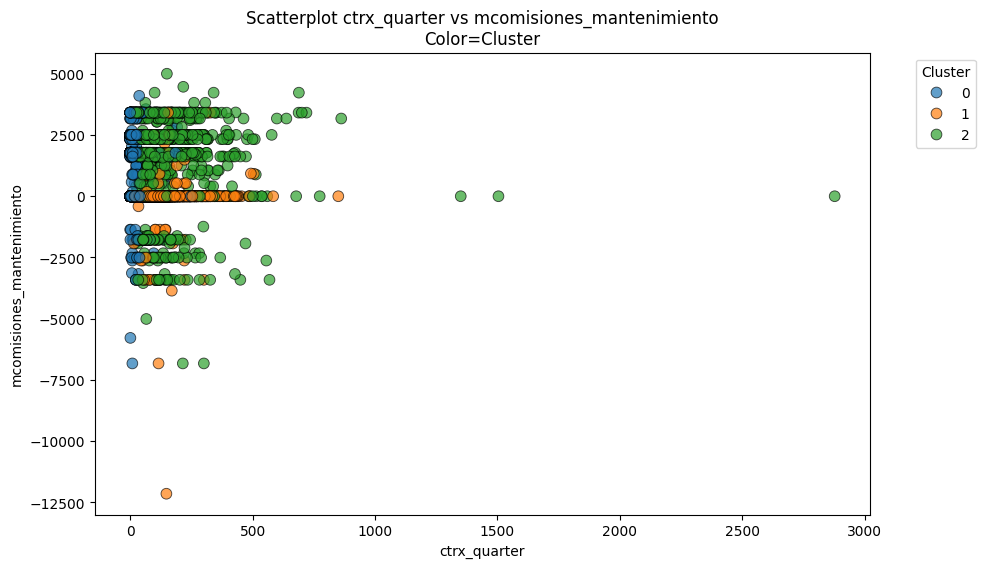

In [33]:
def scatter_clusters(df, x_var, y_var, cluster_col="cluster"):
    """
    Hace un scatterplot entre dos variables donde:
    - Color = cluster
    """
    # Paleta de colores para clusters
    palette = sns.color_palette("tab10", df[cluster_col].nunique())
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df,
        x=x_var,
        y=y_var,
        hue=cluster_col,
        palette=palette,
        edgecolor="black",
        alpha=0.7,
        s=60
    )
    
    plt.title(f"Scatterplot {x_var} vs {y_var}\nColor=Cluster")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
    # plt.ylim(0, 1e6)
    # plt.xlim(0,600)
    plt.show()

# Ejemplo de uso:
scatter_clusters(df_with_target, "ctrx_quarter", "mcomisiones_mantenimiento")


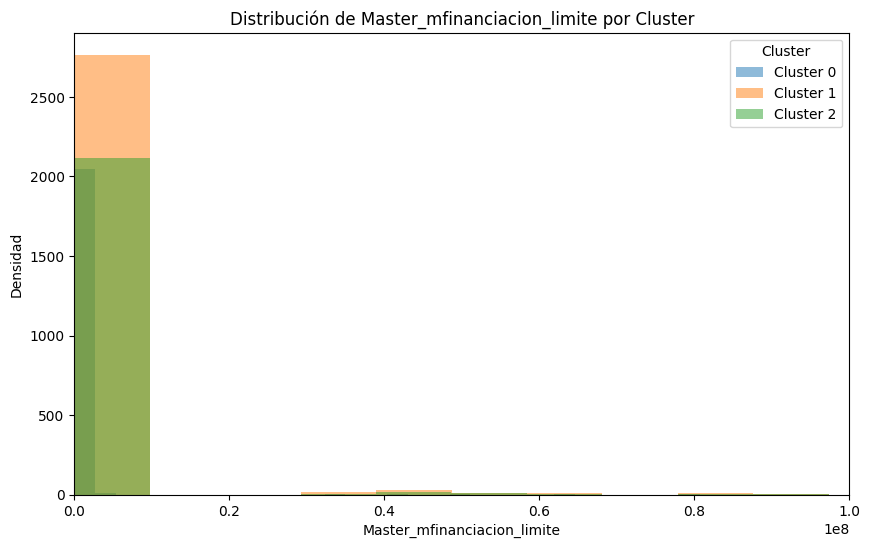

In [34]:
def histogram_by_cluster(df, variable, cluster_col="cluster", bins=30):
    """
    Dibuja histogramas superpuestos de una variable,
    diferenciados por cluster con colores distintos y transparencia.
    """
    plt.figure(figsize=(10, 6))
    palette = sns.color_palette("tab10", df[cluster_col].nunique())
    
    for i, cluster in enumerate(sorted(df[cluster_col].unique())):
        cluster_data = df[df[cluster_col] == cluster][variable]
        plt.hist(
            cluster_data,
            bins=bins,
            alpha=0.5,               # Transparencia para superposición
            color=palette[i],
            label=f"Cluster {cluster}",
            density=False              # Normaliza para comparar distribuciones
        )
    
    plt.title(f"Distribución de {variable} por Cluster")
    plt.xlabel(variable)
    plt.ylabel("Densidad")
    plt.legend(title="Cluster")
    plt.xlim(0,1e8)
    plt.show()

# Ejemplo de uso:
histogram_by_cluster(df_with_target, "Master_mfinanciacion_limite")